In [35]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
%reload_ext autoreload

In [37]:
# Standart Libraries

import numpy as np

# Import files

import utilities
from Filter import ExtendedKalmanFilter
from Radar import Radar
from RadarSystem import RadarSystem
from Earth import Earth
from Satellite import Satellite
from SatelliteState import SatelliteState

from config import config


In [38]:
# Initialize Earth
earth = Earth()


# Initialize RadarSystem
# Beijing Aerospace Command and Control Center

BACC =  RadarSystem(Earth(), 200)


# Initialize Satellite
#R = config['satellite']['initial_conditions']['distance']
R = 6378136 + 200e3
theta = config['satellite']['initial_conditions']['polar_angle']
phi = config['satellite']['initial_conditions']['azimuthal_angle']




#angular_vel = 0.0010830807404
angular_vel = 0.0011833599626 
#angular_vel = 0.0011833599626 Ashleighs mean_0 = np.array([R, 0, 0, np.pi/2, angular_vel, 0])
#angular_vel = 2
tang_vel = angular_vel * R
radial_velocity = 0
azimuthal_velocity = 0


sat_state = SatelliteState(np.array([R, theta, phi]), np.array([0]), np.array([radial_velocity, tang_vel, azimuthal_velocity]), np.array([0]))
tiagong = Satellite(sat_state, 0, earth=earth)

In [39]:
list_position = np.array([radar.position for radar in BACC.radars])


In [40]:
# Initialize the Kalman Filter
# tianhe is the chinese super computer

#mean_0 = np.array([earth.re+380000, 0, 0.1, np.pi/2, angular_vel, 0])
r_noise = config['radar']['noise']['rho']
t_noise = config['radar']['noise']['theta']
mean_0 = np.array([R + 1000, 0.1, 0.1, np.pi/2, 5000, 0.1])

# cov_0 = np.array([
#     [3.98e8, 0, 0, 0, 0, 0],
#     [0, 1.092e1, 0, 0, 0, 0],
#     [0, 0, 1e0, 0, 0, 0],
#     [0, 0, 0, 1.9533, 0, 0],
#     [0, 0, 0, 0, 5.194e-1, 0],
#     [0, 0, 0, 0, 0, 8.03e-2]
# ])

cov_0 = np.array([
    [1e4, 0, 0, 0, 0, 0],
    [0, 1e1, 0, 0, 0, 0],
    [0, 0, 1e0, 0, 0, 0],
    [0, 0, 0, 1e1, 0, 0],
    [0, 0, 0, 0, 1e0, 0],
    [0, 0, 0, 0, 0, 1e-2]
])

observation_noise = np.array([[10e2, 0],
              [0, 1e-1]])

Q = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]
])

tianhe = ExtendedKalmanFilter(mean_0, cov_0, earth, observation_noise=observation_noise, process_noise=Q)


In [41]:
n = 100000
simulation = tiagong.simulate(n)

sim_lenght = len(simulation.y[0])


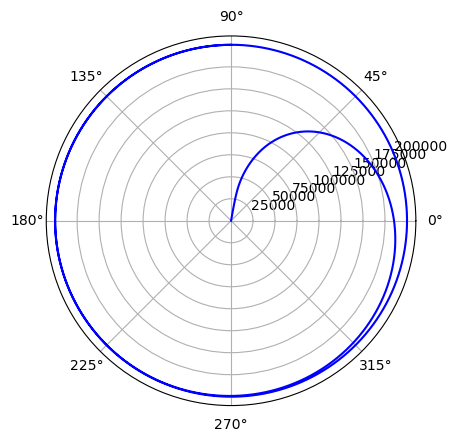

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d

#n=np.argmin(np.abs(sol.y[0]-earth_radius))

R = simulation.y[0][:]-6378136.6
rad = simulation.y[2][:]
Phi = [np.pi/2 - theta for i in rad]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='b')

plt.show()

In [43]:
predicted_states_satellite_cord = []
radar_states_satellite_cord = []

In [44]:
revolution = 0
loop = False
for i in range(int(sim_lenght)):
    
    if i < sim_lenght:
        current_state_satellite_cord = tiagong.get_position_at_t(i)
        current_state_earth_cord = utilities.spherical_to_spherical(current_state_satellite_cord)
        #current_state_earth_cord = current_state_satellite_cord
        noise_states_earth_cord = BACC.try_detect_satellite(current_state_earth_cord, i)

        if len(noise_states_earth_cord) > 0:
            #print("Enter")
            flag = 0
            for state_earth_cord in noise_states_earth_cord:
                #state_satellite_cord = np.array([0,0,0])
                state_satellite_cord = utilities.earth_to_orbit(state_earth_cord.pos)

                #tracks the number of times the satellite has passed the radian axis and adjusts angle accordingly
                #essentially the radars being like you passed me twice here have 2 lots of 2pi
                if state_satellite_cord[1] < np.pi/4:
                    state_satellite_cord[1] += 2*np.pi*(revolution + 1)
                    loop = True
                elif loop == True and state_satellite_cord[1] >= np.pi/4:
                    revolution += 1
                    state_satellite_cord[1] += 2*np.pi*revolution
                    loop = False
                else:
                    state_satellite_cord[1] += 2*np.pi*revolution
                #state_satellite_cord = state_earth_cord.pos
                
                new_state_satellite_cord = tianhe.update(state_satellite_cord)

                if flag == 0:
                    #print(state_satellite_cord)
                    radar_states_satellite_cord += state_satellite_cord,
                    flag = 1
         
    forecast = tianhe.forecast()
    new_state_satellite_cord = [forecast[0][0][0], forecast[0][3][0]]

    predicted_states_satellite_cord += new_state_satellite_cord,

    #if earth.distance_to_surface(utilities.spherical_to_spherical(np.array([forecast[0][0][0], forecast[0][3][0], config['satellite']['initial_conditions']['azimuthal_angle']])))['inside']:
        #break




In [45]:
print(predicted_states_satellite_cord[-1])
print(predicted_states_satellite_cord)
R2, rad2 = np.array(predicted_states_satellite_cord[:]).T
R2 = R2 - 6378136.6
Phi = [np.pi/2 - config['satellite']['initial_conditions']['polar_angle'] for i in rad]

[6376414.976808689, 13.955671114081394]
[[6579136.1, 1.5715563050048014], [6579136.3, 1.5723162984027188], [6579131.091105935, 1.5730762917863659], [6579120.473470025, 1.5738362857921067], [6579104.447092802, 1.5745962804199258], [6579083.011962897, 1.5753562756698252], [6578132.5481730485, 1.578648056379619], [6578094.538665186, 1.5794081554432535], [6578051.118186356, 1.580168255129309], [6578002.286632653, 1.5809283554377973], [6577948.043881889, 1.5816884563687326], [6577888.3897935925, 1.582448557922131], [6577944.446733692, 1.584480535818496], [6577883.977528672, 1.5852406399863812], [6577818.096844109, 1.5860007447767481], [6577746.804500205, 1.5867608501896173], [6577670.10029888, 1.5875209562250114], [6577587.984023759, 1.5882810628829556], [6577955.820812817, 1.5903117979306953], [6577898.231679151, 1.5910719370902706], [6577835.231444566, 1.5918320768723127], [6577766.81993899, 1.592592217276841], [6577692.996974071, 1.5933523583038771], [6577613.7623431645, 1.59411249995344

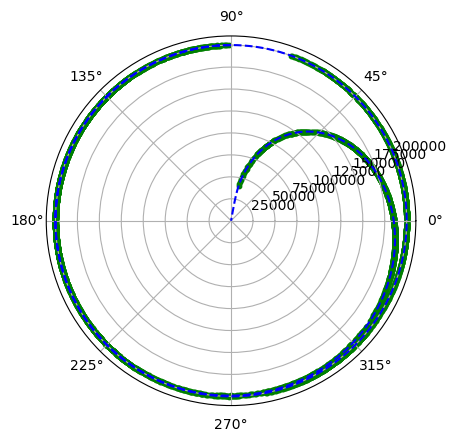

10512


In [46]:
radar_states_satellite_cord

R3, rad3 = np.array(radar_states_satellite_cord[1:]).T
R3 = R3 - 6378136.6

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

colors = plt.cm.rainbow(np.linspace(0, 1, len(R2[:3988])))

ax.plot(rad, R, c='b', linestyle="dashed",)
ax.scatter(rad3, R3, c='g', s = 10)

plt.show()

print(len(R2))

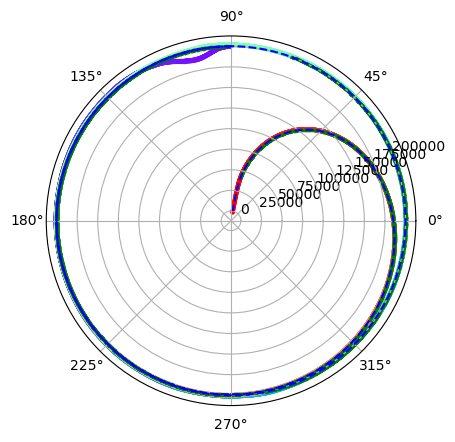

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

colors = plt.cm.rainbow(np.linspace(0, 1, len(R2)))

ax.plot(rad, R, c='b', linestyle="dashed")
ax.scatter(rad2, R2, c=colors, s=5)
ax.scatter(rad3, R3, c='g', s = 2)


plt.show()

In [48]:
R2, rad2 = np.array(predicted_states_satellite_cord[:]).T
trd = [np.pi/2 - theta]*len(R2)
predicted_states_earth_coord = np.array([utilities.spherical_to_spherical(np.array([R2, rad2, trd]).T[i]) for i in range(len(predicted_states_satellite_cord))])

R1 = simulation.y[0][:]
rad1 = simulation.y[2][:]
trd = [np.pi/2 - theta]*len(R1)
true_states_earth_coord = np.array([utilities.spherical_to_spherical(np.array([R1, rad1, trd]).T[i]) for i in range(len(R1))])

In [49]:
earth = Earth()

pred_heights = np.zeros(len(predicted_states_earth_coord))
true_heights = np.zeros(len(true_states_earth_coord))

for i in range(len(pred_heights)):
    pred_heights[i] = earth.distance_to_surface(predicted_states_earth_coord[i])['distance']

for i in range(len(true_heights)):
    true_heights[i] = earth.distance_to_surface(true_states_earth_coord[i])['distance']

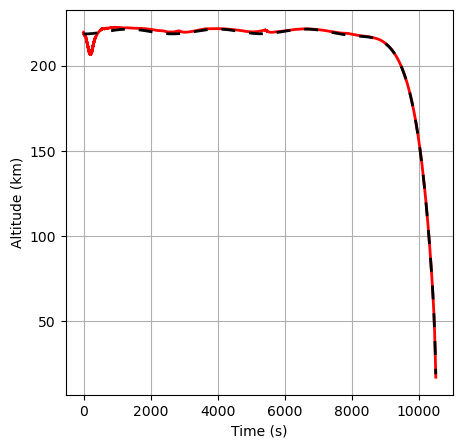

In [92]:
fig, ax = plt.subplots(figsize = (5, 5))

ax.plot(pred_heights/1000, c = 'red', linewidth = 2)
ax.plot(true_heights/1000, c = 'black', linestyle = (0, (5,5)), linewidth = 2)

ax.grid()
ax.set(xlabel = 'Time (s)', ylabel ='Altitude (km)')
plt.show()

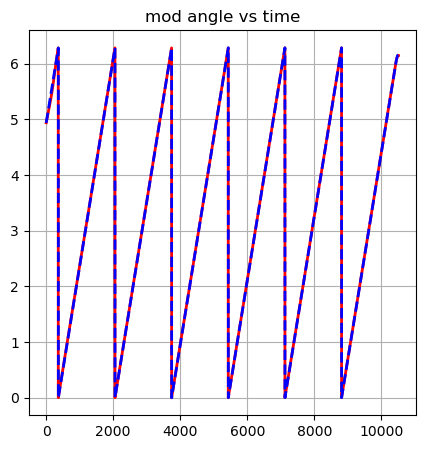

In [51]:
fig, ax = plt.subplots(figsize = (5, 5))

ax.plot(rad2%2*np.pi, c = 'r', linewidth = 2)
ax.plot(rad1%2*np.pi, c = 'b', linestyle = 'dashed', linewidth = 2)

ax.grid()
ax.set_title('mod angle vs time')
plt.show()

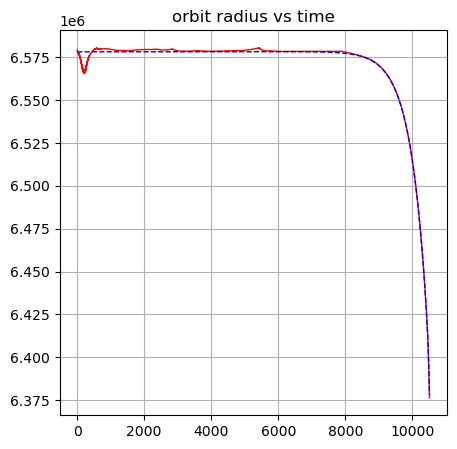

In [53]:
fig, ax = plt.subplots(figsize = (5, 5))

ax.plot(R2, c = 'r', linewidth = 1)
ax.plot(R1, c = 'b', linestyle = 'dashed', linewidth = 1)

ax.grid()
ax.set_title('orbit radius vs time')
plt.show()

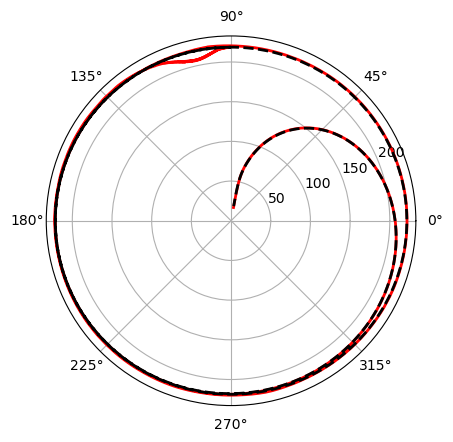

In [98]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})


ax.plot(rad2, pred_heights/1000, c = 'r', linewidth = 2, label = 'Predicited orbit')
ax.plot(rad1, true_heights/1000, c='black' , linestyle = 'dashed', linewidth = 2, label = 'Simulated orbit')

plt.show()

In [175]:
R2, rad2 = np.array(predicted_states_satellite_cord[:]).T
trd = [np.pi/2 - theta]*len(R2)

In [176]:
predicted_states_earth_cord = np.array([utilities.spherical_to_spherical(np.array([R2,rad2,trd]).T[i]) for i in range(len(predicted_states_satellite_cord))])

In [177]:
x, y, z = utilities.earth_to_xyz_bulk(predicted_states_earth_cord).T

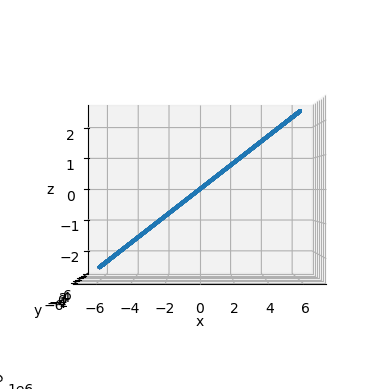

In [178]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.scatter(x, y, z, s = 3)


ax.view_init(0, -90)
ax.set_xlim([-7e6, 7e6])
ax.set_ylim([-7e6, 7e6])

ax.set(xlabel = 'x', ylabel = 'y', zlabel = 'z')

plt.show()

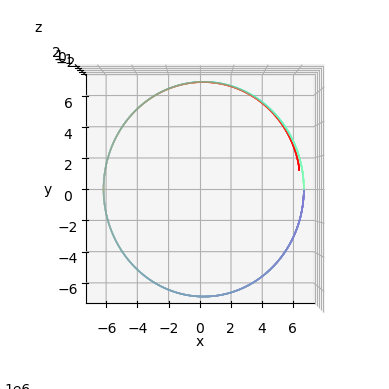

In [179]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

colors = plt.cm.rainbow(np.linspace(0, 1, len(x)))

plot = ax.scatter(x, y, z, c=colors, s = 0.01)

ax.view_init(90, -90)
ax.set_xlim([-7e6, 7e6])
ax.set_ylim([-7e6, 7e6])

ax.set(xlabel = 'x', ylabel = 'y', zlabel = 'z')

plt.show()

In [180]:
from main import Main
import matplotlib.pyplot as plt
import numpy as np
from config import config
import utilities

In [181]:
#main = Main(200)

In [182]:
main.simulate()

NameError: name 'main' is not defined

In [ ]:
main.predict()

In [ ]:
R, rad, R2, rad2, R3, rad3 = main.output() # True, predicted, radar

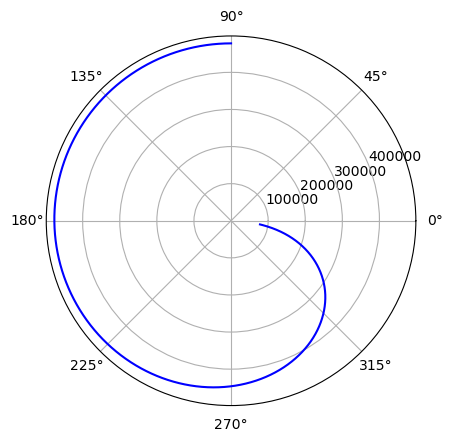

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R-6300000, c='b')

plt.show()

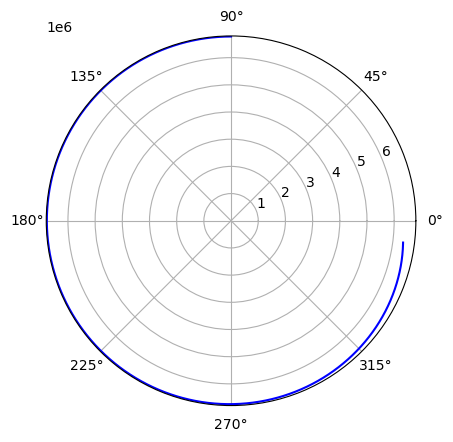

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(rad, R, c='b')

plt.show()

In [ ]:
trd = [config['satellite']['initial_conditions']['orbital_inclination']]*len(R)

In [ ]:
predicted_states_earth_cord = np.array([utilities.spherical_to_spherical(np.array([R,rad,trd]).T[i]) for i in range(len(R))])

In [ ]:
x, y, z = utilities.earth_to_xyz_bulk(predicted_states_earth_cord).T

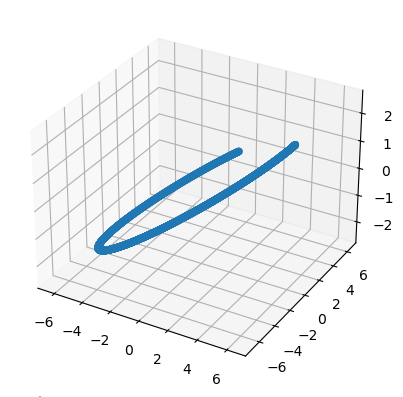

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.scatter(x, y, z)

plt.show()

In [ ]:
[main.BACC.radars[i].position

array([6.35718287e+06, 2.99879573e+00, 2.45855672e+00])

In [ ]:
main.BACC.radars